# Final project
### Plant disease detection --> multiclassification problem

### VGG16 model

1. Install the packages, create functions

In [48]:
# Dowload the packages
!pip install split-folders

In [49]:
# Dowload the packages
import numpy as np
import pandas as pd
import os,os.path
import splitfolders
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib

import keras.backend as K
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

matplotlib.style.use('ggplot')
%matplotlib inline

In [50]:
# Set some default variables
DATA_DIR = '/kaggle/input/plantvillage-dataset/color'
BATCH_SIZE = 64
EPOCHS = 5
IMAGE_SHAPE = (224, 224)

In [51]:
# The function for computing f1 score (macro) for multiclass classification in Keras
def f1_macro(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

2. Upload and explore the data

In [52]:
# Check the content

pairs = list()
number = list()

for directory in os.listdir(path=DATA_DIR):
    columns = directory.split('___')
    columns.append(directory)
    
    sub_path = DATA_DIR + '/' + directory
    columns.append(len([name for name in os.listdir(path=sub_path)]))
    
    pairs.append(columns)
    
pairs = pd.DataFrame(pairs, columns=['Plant', 'Disease', 'Directory', 'Files'])
pairs.sort_values(by='Plant')

,Plant,Disease,Directory,Files
27,Apple,healthy,Apple___healthy,1645
20,Apple,Cedar_apple_rust,Apple___Cedar_apple_rust,275
16,Apple,Black_rot,Apple___Black_rot,621
13,Apple,Apple_scab,Apple___Apple_scab,630
17,Blueberry,healthy,Blueberry___healthy,1502
18,Cherry_(including_sour),Powdery_mildew,Cherry_(including_sour)___Powdery_mildew,1052
30,Cherry_(including_sour),healthy,Cherry_(including_sour)___healthy,854
31,Corn_(maize),Common_rust_,Corn_(maize)___Common_rust_,1192
10,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,513
37,Corn_(maize),healthy,Corn_(maize)___healthy,1162


There are some pairs when only a healthy plant is present. These are Blueberry (17), Orange (3), Raspberry (33), Soybean (4), Squash (5). These are not exactly interesting for us, because we want to detect diseases. Therefore, we will delete these observations in the future.

In [10]:
# Save the directories to be deleted
rows_to_drop = [17, 3, 33, 4, 5]
dir_to_delete = pairs[pairs.index.isin(rows_to_drop)]['Directory']
print(dir_to_delete.values)

['Orange___Haunglongbing_(Citrus_greening)' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Blueberry___healthy' 'Raspberry___healthy']


In [53]:
# Make a directory images
os.mkdir('images')

# Make subdirectories train, val, test
os.mkdir(os.path.join('images', 'train'))
os.mkdir(os.path.join('images', 'val'))
os.mkdir(os.path.join('images', 'test'))

In [54]:
# Split the data into folders
splitfolders.ratio(DATA_DIR,output = "images",seed = 42,ratio = (0.80,0.10,0.10))

Copying files: 54305 files [01:53, 478.55 files/s] 


In [55]:
# Remove the directories we saved before

TRAIN_PATH = "./images/train"
VAL_PATH = "./images/val"
TEST_PATH  = "./images/test"
PATHS = [TRAIN_PATH, VAL_PATH, TEST_PATH]

for sub_directory in dir_to_delete.values:
    for directory in PATHS:
        d = directory + '/' + sub_directory
        shutil.rmtree(d)

In [56]:
# Generate batches of tensor image data with real-time data augmentation

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

test_gen = datagen.flow_from_directory(directory = TEST_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          shuffle = False)

Found 31987 images belonging to 33 classes.
Found 3988 images belonging to 33 classes.
Found 4025 images belonging to 33 classes.


3. Make a model

In [57]:
# Make a directory for models
os.mkdir('models')

# Make subdirectories train, val, test
os.mkdir(os.path.join('models', 'first_version'))

In [58]:
# Here we create checkpoint for the first model
CHECKPOINT_PATH_MODEL_FIRST = "./models/first_version"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH_MODEL_FIRST,
                                      monitor='val_loss',
                                      save_best_only=True)

In [59]:
# Set early stopping for 2 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True)

In [60]:
# Here VGG16 pretrained model is downloaded
#We do not include the last dense layers by setting include_top parameter to False 
vgg16_base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')

In [61]:
# We fix the parameters of the pretrained model
vgg16_base_model.trainable = False

In [62]:
# Here we add final layers to the first model
inputs = vgg16_base_model.input

x = BatchNormalization()(vgg16_base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.45, seed=1234)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45, seed=1235)(x)
x = Flatten()(x)

outputs = Dense(33, activation='softmax')(x)

vgg16_model = Model(inputs=inputs, outputs=outputs)

In [63]:
# Here we check if everything is okay with the model
vgg16_model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=[f1_macro]
)

In [64]:
# Here we fit the model
history = vgg16_model.fit(train_gen, epochs=EPOCHS, validation_data=val_gen, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/5
500/500 [==============================] - 131s 249ms/step - loss: 1.7119 - f1_macro: 0.4441 - val_loss: 0.6664 - val_f1_macro: 0.7808
Epoch 2/5
500/500 [==============================] - 117s 233ms/step - loss: 0.8197 - f1_macro: 0.7332 - val_loss: 0.4403 - val_f1_macro: 0.8539
Epoch 3/5
500/500 [==============================] - 118s 236ms/step - loss: 0.6093 - f1_macro: 0.8003 - val_loss: 0.3592 - val_f1_macro: 0.8831
Epoch 4/5
500/500 [==============================] - 119s 239ms/step - loss: 0.5073 - f1_macro: 0.8333 - val_loss: 0.3124 - val_f1_macro: 0.8963
Epoch 5/5
500/500 [==============================] - 119s 238ms/step - loss: 0.4402 - f1_macro: 0.8534 - val_loss: 0.2858 - val_f1_macro: 0.9017


In [65]:
results = vgg16_model.evaluate(test_gen, verbose=1)

63/63 [==============================] - 13s 209ms/step - loss: 0.2692 - f1_macro: 0.9063


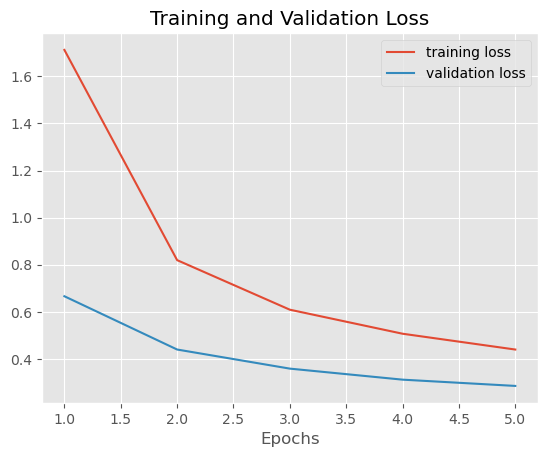

In [66]:
# Here we make the first plot for Loss
Epochs = [i+1 for i in range(len(history.history['f1_macro']))]

plt.plot(Epochs, history.history['loss'], label = 'training loss')
plt.plot(Epochs, history.history['val_loss'], label = 'validation loss')
plt.grid(True)
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.show()

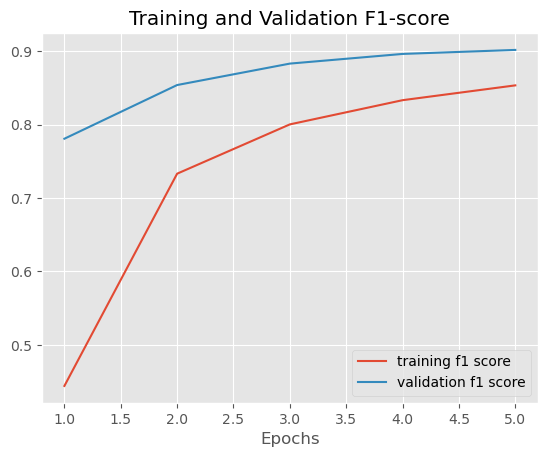

In [68]:
# Here we make the first plot for F1-score
Epochs = [i+1 for i in range(len(history.history['f1_macro']))]

plt.plot(Epochs, history.history['f1_macro'], label = 'training f1 score')
plt.plot(Epochs, history.history['val_f1_macro'], label = 'validation f1 score')
plt.grid(True)
plt.legend()
plt.title('Training and Validation F1-score')
plt.xlabel('Epochs')
plt.show()